In [57]:
# get_ipython().magic('matplotlib notebook')
# get_ipython().magic('matplotlib inline')
# get_ipython().magic('load_ext autoreload')
# get_ipython().magic('autoreload 2')
%matplotlib inline
%load_ext autoreload
%autoreload 2

#___________________________________________________________________________________________________________________
import os
import tripyview as tpv
import numpy     as np
import xarray    as xr
import time      as clock
import warnings
xr.set_options(keep_attrs=True)
do_parallel       = False
parallel_nprc     = 48   # number of dask workers
parallel_nprc_bin = 10   # number of processor used to parallize the binning loop
parallel_tmem     = 200  # max. available RAM

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### INFO:
To compute especially on large unstructured grids #vertices>1M, you need to run this notebook in parallel (do_parallel=True) on several workers (parallel_nprc...is the number of dask worker that can be allocated, parallel_tmem...is the maximum available RAM that will be distributed between the dask workers). Therefor allocate a full !!! COMPUTE NODE !!! (admins might not be happy if you do this in parallel on a login node) of a HPC of your choice with as much memory (RAM) as you can get to run this notebook!

In [58]:
if do_parallel:
    from dask.distributed import Client
    # from dask.diagnostics import ProgressBar
    import dask
    print(' --> memory_limit: {:3.3f} GB'.format(parallel_tmem/(parallel_nprc)))
    ## dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
    client = Client(n_workers=parallel_nprc, threads_per_worker=1, memory_limit='{:3.3f} GB'.format(parallel_tmem/parallel_nprc))
    client

In [59]:
# Parameters
# mesh_path ='/work/ollie/projects/clidyn/FESOM2/meshes/core2/'
mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node/'
# mesh_path = '/albedo/work/user/pscholz/mesh_fesom2.0/dart_test/'
save_path = None #'~/figures/test_papermill/'
save_fname= None

#_____________________________________________________________________________________
which_cycl= None #5 # set None --> take path as in input_paths otherwise add dir of cycle

#_____________________________________________________________________________________
input_paths= list()
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/')
input_paths.append('/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/')

input_names= list()
input_names.append('TKE+IDEMIX, jayne')
input_names.append('TKE+IDEMIX, nycander')
input_names.append('TKE+IDEMIX, stormtide')
input_names.append('TKE')

vname     = 'gmoc' # 'gmoc', 'amoc', 'aamoc', 'ipmoc', 'pmoc', 'imoc'
year      = [1979,2019]
mon, day, record, box, depth = None, None, None, None, None

#_____________________________________________________________________________________
# do anomaly plots in case ref_path is not None
ref_path  = None # '/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/' # None
ref_name  = None # 'TKE' # None
ref_year  = None #[1979,2019]
ref_mon, ref_day, ref_record = None, None, None

#_____________________________________________________________________________________
cstr, cnum  = 'blue2red', 15
cref, crange, cmin, cmax, cfac, climit = 0.0, None, None, None, None, None
chist, ctresh = True, 0.995

ref_cstr, ref_cnum = 'grads', 15
ref_cref, ref_crange, ref_cmin, ref_cmax, ref_cfac, ref_climit = 0.0, None, None, None, None, None
ref_chist, ref_ctresh = True, 0.995

#_____________________________________________________________________________________
ncol              = 2      # number of pannel columns in figure
do_plt            = 'tcf'  # plot pcolor (tpc) or contourf (tcf)
plt_contb         = True   # background contour line (thin)
plt_contf         = True  # contour line of main colorbar steps 
plt_contr         = False  # contour line of reference value 
plt_contl         = False  # label contourline of main colorbar steps 
do_rescale        = None   # rescale data: None, 'log10', 'slog10', np.array(...)
do_lsm            ='fesom' # 'fesom', 'bluemarble', 'etopo', 'stock'
do_mesh, mesh_opt = False, dict({'color':'k', 'linewidth':0.10})
do_enum           = False  # do enumeration of panels
do_reffig         = True   # plot reference fig when doing anomalies 
# do_clim           = False   # plot climatolgy values when doing absoluts
ax_title          = None
cb_label          = None
save_dpi          = 300
save_fmt          = ['png']
do_bolus          = True

In [60]:
#___LOAD FESOM2 MESH___________________________________________________________________________________
mesh=tpv.load_mesh_fesom2(mesh_path, do_rot='None', focus=0, do_info=True, do_pickle=True)

#______________________________________________________________________________________________________
if (which_cycl is not None): 
    for ii,ipath in enumerate(input_paths):
        input_paths[ii] = os.path.join(ipath,'{:d}/'.format(which_cycl))
        print(ii, input_paths[ii])
        
    if (ref_path is not None): 
        ref_path = os.path.join(ref_path,'{:d}/'.format(which_cycl))
        print('R', ref_path)
    
#______________________________________________________________________________________________________        
cinfo=tpv.set_cinfo(cstr, cnum, crange, cmin, cmax, cref, cfac, climit, chist, ctresh)
ref_cinfo=None
if (ref_path is not None) and (ref_path != "None"): 
    if ref_year   is None: ref_year   = year
    if ref_mon    is None: ref_mon    = mon
    if ref_record is None: ref_record = record    
    cinfo['cref']=0.0 
    ref_cinfo=tpv.set_cinfo(ref_cstr, ref_cnum, ref_crange, ref_cmin, ref_cmax, ref_cref, ref_cfac, ref_climit, ref_chist, ref_ctresh)    
    ref_cinfo['cref']=0.0 
    
#______________________________________________________________________________________________________    
# concatenate list = list1+list2
if (ref_path is not None) and (ref_path != "None"): 
    if isinstance(ref_path, list): 
        input_paths, input_names = ref_path + input_paths        , ref_name + input_names
    else:    
        input_paths, input_names = list([ref_path]) + input_paths, list([ref_name]) + input_names

 > found *.pckl file: /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > load  *.pckl file: tripyview_fesom2_core2_srt_dep@node_focus0.pckl
___FESOM2 MESH INFO________________________
 > path            = /albedo/work/user/pscholz/mesh_fesom2.0/core2_srt_dep@node
 > id              = core2_srt_dep@node
 > do rot          = None
 > [al,be,ga]      = 50, 15, -90
 > do augmpbnd     = True
 > do cavity       = False
 > do lsmask       = True
 > do earea,eresol = True, False
 > do narea,nresol = True, False
___________________________________________
 > #node           = 126858
 > #elem           = 244659
 > #lvls           = 48
___________________________________________


/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_jayne_bin_ck0.1/5/ TKE+IDEMIX, jayne
 --> elasped time to load data: 0.53 min.
 --> data uses 0.05 Gb:



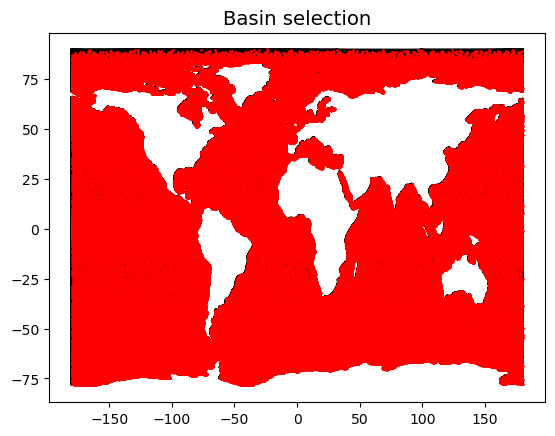

 --> elasped time to compute moc: 0.02 min.
 --> data uses 0.00 Gb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_nycander_bin_ck0.1/5/ TKE+IDEMIX, nycander
 --> elasped time to load data: 0.52 min.
 --> data uses 0.05 Gb:

 --> elasped time to compute moc: 0.01 min.
 --> data uses 0.00 Gb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke+idemix_stormtide_bin_ck0.1/5/ TKE+IDEMIX, stormtide
 --> elasped time to load data: 0.53 min.
 --> data uses 0.05 Gb:

 --> elasped time to compute moc: 0.01 min.
 --> data uses 0.00 Gb:

/albedo/work/projects/p_fesom/pscholz/project_TRR181/trr181_tke_ctrl_ck0.1/5/ TKE
 --> elasped time to load data: 0.52 min.
 --> data uses 0.05 Gb:

 --> elasped time to compute moc: 0.01 min.
 --> data uses 0.00 Gb:



In [61]:
aux_vname, aux_vnamebv = 'w', 'bolus_w'
#______________________________________________________________________________________________________    
flag_checkb = True
data_list = list()
for ii, (datapath, descript) in enumerate(zip(input_paths, input_names)): 
    print(datapath, descript)
    ts = clock.time()
    #__________________________________________________________________________________________________
    # load data
    data = tpv.load_data_fesom2(mesh, datapath, vname=aux_vname, year=year, descript=descript, 
                                do_info=False, do_zarithm=None, do_nan=False, #chunks=chunks,
                                do_load=False, do_persist=True, )
    
    # check if data where loaded
    if data is None: raise ValueError(f'data == None, data could not be readed, your path:{datapath} might be wrong!!!')
    
    # load bolus velocities
    if do_bolus: data[aux_vname].data = data[aux_vname].data+tpv.load_data_fesom2(mesh, datapath, vname=aux_vnamebv, year=year, 
                                        do_info=False, do_zarithm=None, do_nan=False,
                                        do_load=False, do_persist=True, )[aux_vnamebv].data
    
    print(' --> elasped time to load data: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(data.nbytes/(1024**3)))
    print('')
    
    #__________________________________________________________________________________________________        
    # compute zmoc  
    ts = clock.time()
    zmoc     = tpv.calc_zmoc(mesh, data, dlat=1.0, which_moc=vname, do_info=False, do_checkbasin=flag_checkb,
                             do_onelem=False, do_load=True, do_parallel=do_parallel, n_workers=parallel_nprc_bin)
    print(' --> elasped time to compute moc: {:3.2f} min.'.format( (clock.time()-ts)/60  ))        
    print(' --> data uses {:3.2f} Gb:'.format(zmoc.nbytes/(1024**3)))
    print('')
    flag_checkb = False
    del(data)
    
    #__________________________________________________________________________________________________        
    # compute absolute or anomalie    
    if (ref_path is not None): 
        if ii == 0: 
            zmoc_ref = zmoc.copy()
            if do_reffig: data_list.append(zmoc_ref) 
        else:        
            data_list.append( tpv.do_anomaly(zmoc, zmoc_ref) )
    else:                                                   
        data_list.append( zmoc )
    del(zmoc)        
if (ref_path is not None): del(zmoc_ref)    

--> histo: cmin, cmax =  -18.938888549804688 15.816545486450195
--> histo: cmin, cmax =  -18.938888549804688 19.703147888183594
--> histo: cmin, cmax =  -18.938888549804688 19.831926345825195
--> histo: cmin, cmax =  -18.938888549804688 19.831926345825195
{'cstr': 'blue2red', 'cnum': 15, 'cref': 0.0, 'chist': True, 'ctresh': 0.995, 'cnlab': 8, 'cmin': -18.94, 'cmax': 19.83, 'cmap': <matplotlib.colors.ListedColormap object at 0x15503f85f190>, 'clevel': array([-20. , -17.5, -15. , -12.5, -10. ,  -7.5,  -5. ,  -2.5,   0. ,
         2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ]), 'clab': array([-15. ,  -7.5,   0. ,   7.5,  15. ])}


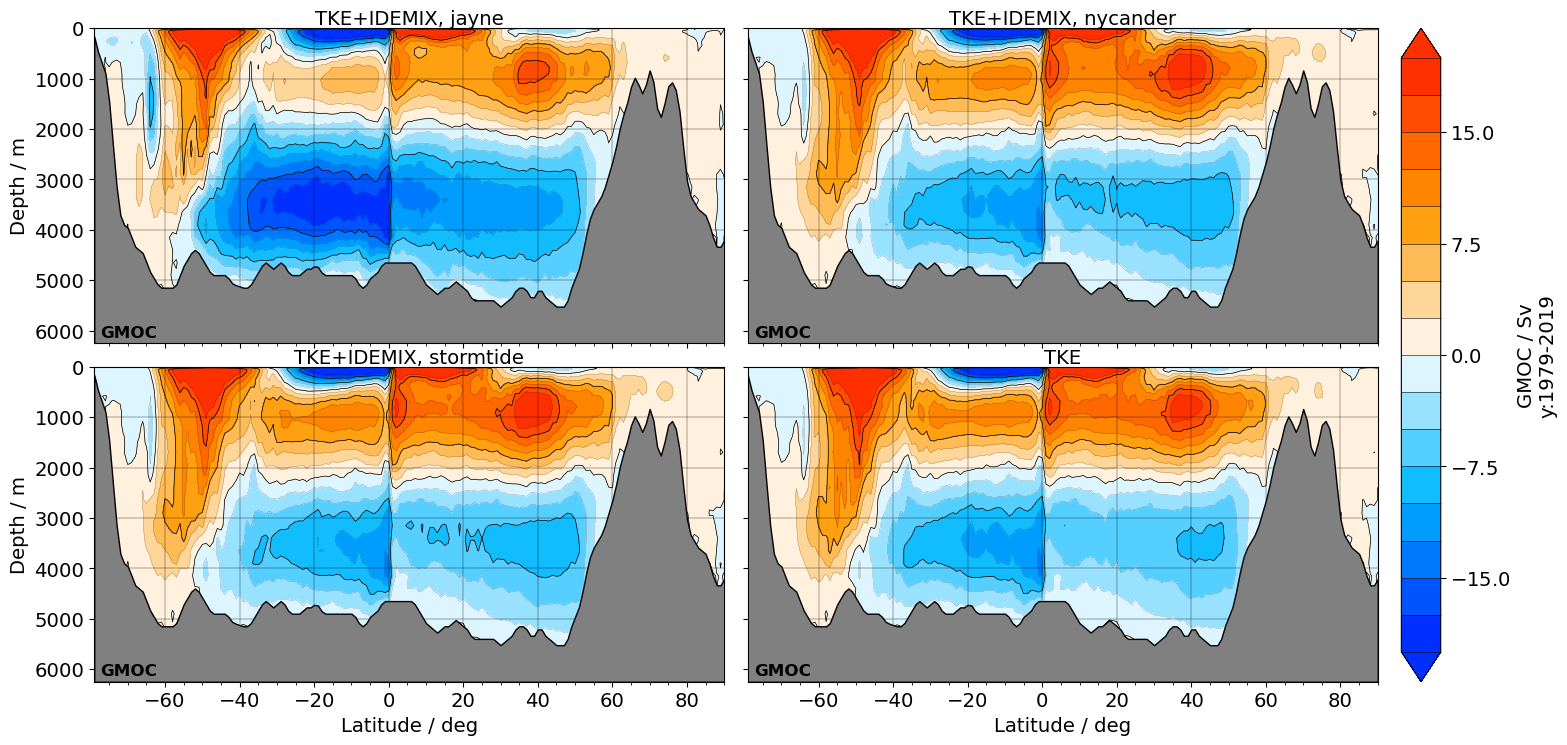

In [62]:
#___PLOT ZONMEAN TRANSECT______________________________________________________________________________
spath  = save_path
ncol0  = np.min([ncol,len(data_list)])    
nrow0  = np.ceil(len(data_list)/ncol0).astype('int')
svname = list(data_list[0].data_vars)[0]
slabel = data_list[0][svname].attrs['str_lsave']
stname = data_list[0][svname].attrs['short_name'].replace(' ','_').lower()
#__________________________________________________________________________________________________
# do save filename path
sfpath = None
if spath!=None: 
    sfpath=list()
    for sfmt in save_fmt: sfpath.append( os.path.join(spath,'{:s}_{:s}_{:s}_{:s}.{:s}'.format(svname, 'zmoc', stname ,slabel, sfmt)) )
    
#__________________________________________________________________________________________________
# do colorbar either single cbar or ref_cbar + anom_cbar
if (ref_path != None) and do_reffig: cb_plt, cb_plt_single, cinfo0 = [1]+[2]*(nrow0*ncol0-1), False, [ref_cinfo.copy(), cinfo.copy()]
else: cb_plt, cb_plt_single, cinfo0 = True, True, cinfo.copy() 
    
#__________________________________________________________________________________________________    
hfig, hax, hcb = tpv.plot_vslice(mesh, data_list, nrow=nrow0, ncol=ncol0, cinfo=cinfo0, 
                                    do_plt=do_plt, plt_contb=plt_contb, plt_contf=plt_contf, plt_contr=plt_contr, plt_contl=plt_contl, do_enum=do_enum, 
                                    ax_opt=dict({'fig_sizefac':2.0, 'cb_plt':cb_plt, 'cb_plt_single':cb_plt_single, 'cb_pos':'vertical', 'cb_h':'auto',}), # 'fs_label':14, 'fs_ticks':14, 'ax_dt':1.0}),
                                    cbl_opt=dict(), cb_label=cb_label, cbtl_opt=dict(),
                                    do_save=sfpath, save_dpi=save_dpi )    